Notice: 
- Only train 200 steps of batch 16 (not even close to one epoch of the whole training set)
- Evaluation only done on 1/20 of the true X_test dataset

This is mainly due to the ineffective state of this autograd project

In [35]:
from autograd.engine import Tensor
from autograd.nn import Perceptron, MSELoss
import numpy as np
from tqdm import tqdm
import random

In [36]:
from tinygrad.helpers import fetch
import gzip

# taken from tinygrad.extra.datasets:
def fetch_mnist(tensors=False):
  parse = lambda file: np.frombuffer(gzip.open(file).read(), dtype=np.uint8).copy()
  BASE_URL = "https://storage.googleapis.com/cvdf-datasets/mnist/"   # http://yann.lecun.com/exdb/mnist/ lacks https
  X_train = parse(fetch(f"{BASE_URL}train-images-idx3-ubyte.gz"))[0x10:].reshape((-1, 28*28)).astype(np.float32)
  Y_train = parse(fetch(f"{BASE_URL}train-labels-idx1-ubyte.gz"))[8:].astype(np.int8)
  X_test = parse(fetch(f"{BASE_URL}t10k-images-idx3-ubyte.gz"))[0x10:].reshape((-1, 28*28)).astype(np.float32)
  Y_test = parse(fetch(f"{BASE_URL}t10k-labels-idx1-ubyte.gz"))[8:].astype(np.int8)
  if tensors: return Tensor(X_train).reshape(-1, 1, 28, 28), Tensor(Y_train), Tensor(X_test).reshape(-1, 1, 28, 28), Tensor(Y_test)
  else: return X_train, Y_train, X_test, Y_test

In [37]:
def one_hot_encode(array):
    encoded_array = np.zeros((array.size, array.max()+1), dtype=int)
    encoded_array[np.arange(array.size),array] = 1 
    return encoded_array

In [38]:
X_train, Y_train, X_test, Y_test = fetch_mnist()
X_train, X_test = X_train/255.0, X_test/255.0
Y_train = one_hot_encode(Y_train)
Y_test = one_hot_encode(Y_test)

In [39]:
loss_func = MSELoss()
model = Perceptron([784, 10])
lr = 0.005

In [40]:
def evaluate():
    results = []
    for i in tqdm(range(len(X_test)//20)):
        ypred = model(X_test[i])
        results.append(np.argmax(Y_test[i]) == np.argmax([tensor.item() for tensor in ypred]))
    return round(100 * sum(results) / len(results), 4)

print("Acc: ", evaluate(), "%")

100%|██████████| 500/500 [01:29<00:00,  5.59it/s]

Acc:  7.4 %


In [41]:
steps = 300
batch_size = 32
indexes = list(range(len(X_train)))

In [42]:
ks = []
losses = []

for k in tqdm(range(steps)):
    batch_idx = list(random.sample(indexes, batch_size))
    # forward
    ypreds = [model(X_train[i]) for i in batch_idx]
    ypreds = np.concatenate(ypreds)
    ycorr = np.concatenate([Y_train[i] for i in batch_idx])
    loss = loss_func(ypreds, ycorr)

    # backward
    model.zero_grad()
    loss.backward()

    # update
    for p in model.parameters():
        p.data += -lr * p.grad

    # log
    ks.append(k)
    losses.append(loss.item())

100%|██████████| 300/300 [35:30<00:00,  7.10s/it]


In [43]:
print("Acc: ", evaluate(), "%")

100%|██████████| 500/500 [01:33<00:00,  5.35it/s]

Acc:  46.2 %


Text(0.5, 1.0, 'Loss over time (300 steps @ batch size 32)')

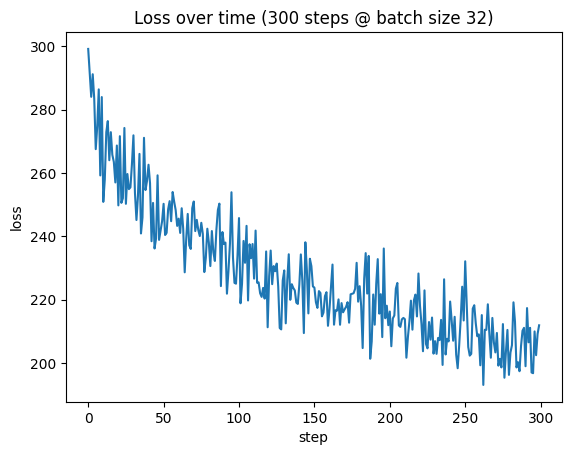

In [46]:
import matplotlib.pyplot as plt
plt.plot(ks, losses)
plt.ylabel("loss")
plt.xlabel("step")
plt.title("Loss over time (300 steps @ batch size 32)")

Visualization

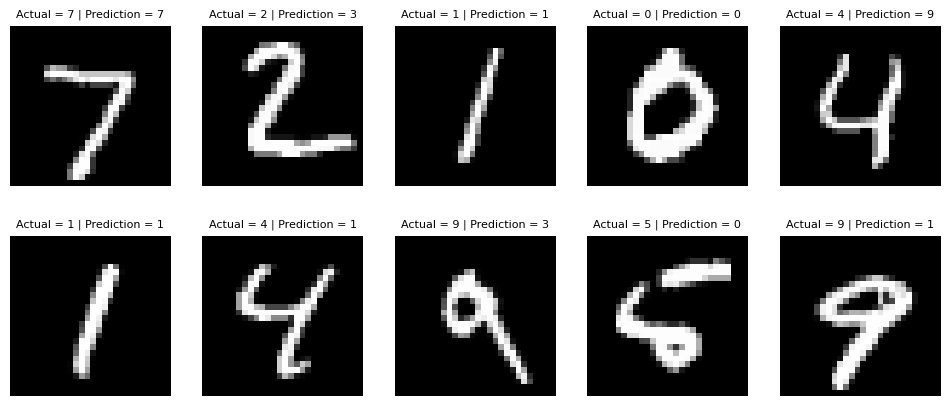

In [45]:
import matplotlib.pyplot as plt

num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5))
for i in range(num_rows * num_cols):
    actual = np.argmax(Y_test[i])
    prediction = np.argmax([t.item() for t in model(X_test[i])])

    image = X_test[i].reshape(28, 28)

    row = i // num_cols
    col = i % num_cols

    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].set_title(f"Actual = {actual} | Prediction = {prediction}", fontsize = 8)
    axes[row, col].axis('off')

plt.show()